## Installs


In [1]:

import torch
from torch import nn, optim
from sae import AutoEncoder
import scanpy as sc
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random

## Dataset

In [2]:
import scanpy as sc

def split_data(X, subject_ids, unique_ids):
  unique_ids = subject_ids.unique()
  data = [[] for _ in range(X.shape[1])]
  sizes = [[] for _ in range(X.shape[1])]
  for i in range(X.shape[1]):
    for j, subject_id in enumerate(unique_ids):
      subject_indices = subject_ids == subject_id
      subject_data = X[subject_indices, i]
      data[i].append(torch.from_numpy(subject_data.toarray()))
      sizes[i].append(torch.tensor([subject_data.shape[0]],dtype = torch.int32))
  return data, sizes

def collate(batch):
      """
      x = torch.cat(data[0], dim=0)
      sizes = torch.cat(sizes[0], dim=0)
      batch = torch.arange(sizes.numel()).repeat_interleave(sizes)
      """
      data = [item[0] for item in batch]
      sizes = [item[1] for item in batch]
      target = [item[2] for item in batch]
      gene = [item[3] for item in batch]
      subject = [item[4] for item in batch]
      x = torch.cat(data, dim=0)
      sizes = torch.cat([item[1] for item in batch], dim=0)
      batch = torch.arange(sizes.numel()).repeat_interleave(sizes)
      target = torch.LongTensor(target)
      gene = torch.LongTensor(gene)
      subject = torch.LongTensor(subject)
      return x, batch, target, gene, subject

class SCDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        adata,
        phenotypes,
        d_output=2, # default binary classification
        dest_path="/content", # default for colab
        return_augs=False,
    ):

        self.return_augs = return_augs
        self.d_output = d_output  # needed for decoder to grab
        self.adata = adata
        self.X  = self.adata.X

        self.num_genes = self.X.shape[1]

        self.subject_ids = self.adata.obs["subject_id"]
        self.unique_ids = self.subject_ids.unique()
        self.num_subjects = len(self.unique_ids)

        self.data, self.sizes = split_data(self.X, self.subject_ids, self.unique_ids)

        self.phenotypes = phenotypes
        self.labels = [self.phenotypes[self.phenotypes['Sample_ID']==int(unique_id)]['binary_y'] for unique_id in self.unique_ids]

    def __len__(self):
        return self.num_genes*self.num_subjects

    def __getitem__(self, idx):
        gene = idx // self.num_subjects
        subject = idx % self.num_subjects
        x = self.data[gene][subject]
        size = self.sizes[gene][subject]
        target = self.labels[subject].item()
        return x, size, target, gene, subject

## Autoencoder Training

In [3]:
def train_autoencoder(model, device, train_loader, optimizer, epoch, log_interval=5000):
    """Training loop."""
    model.train()
    for batch_idx, (data, size, _,_,_) in enumerate(train_loader):
        data, size = data.to(device), size.to(device)
        optimizer.zero_grad()
        xr, batchr = model(data, size)
        loss_data = model.loss()
        loss = loss_data["loss"]
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader),
                100. * batch_idx / len(train_loader), loss.item()))


In [4]:
def test_autoencoder(model, device, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, size, _ ,_,_ in test_loader:
            data, size = data.to(device), size.to(device)
            xr, batchr = model(data, size)
            loss_data = model.loss()
            loss = loss_data["loss"]
            test_loss += loss  # sum up batch loss

    test_loss /= len(test_loader.dataset)

    print(f"Test Loss: {test_loss}")
    #changed
    return test_loss

In [5]:
def run_train_autoencoder(test_subjects=None, hidden_dim =6, weight_decay=.01):

    # experiment settings:
    num_epochs = 220 
    batch_size = 8
    learning_rate = .005  
    weight_decay = weight_decay

    
    hidden_dim = hidden_dim
    dim = 1
    device = 'cuda' if torch.cuda.is_available() else 'cpu'   

    print("Using device:", device)
    

    adata = sc.read("./processed_dataset_16genes.h5ad")
    max_n = adata.obs['subject_id'].value_counts().max()
    model = AutoEncoder(dim=dim, hidden_dim=hidden_dim, max_n=max_n)
    model.to(device)
    phenotypes = pd.read_csv('phenotypes_16gene.csv')
    if test_subjects:
      train_adata = adata[~adata.obs['subject_id'].isin(test_subjects), :]
      test_adata = adata[adata.obs['subject_id'].isin(test_subjects), :]
      train_phenotypes = phenotypes[~phenotypes['Sample_ID'].isin([int(s) for s in test_subjects])]
      test_phenotypes = phenotypes[phenotypes['Sample_ID'].isin([int(s) for s in test_subjects])]

    else:
      train_adata = adata
      test_adata = None
      train_phenotypes = phenotypes
      test_phenotypes = None
    # create datasets
    ds_train = SCDataset(
        adata=train_adata,
        phenotypes=train_phenotypes,
        d_output=2,
        dest_path="/content",
        return_augs=False,
    )
    train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True, collate_fn = collate)
    if test_adata:
      ds_test = SCDataset(
          adata=test_adata,
          phenotypes=test_phenotypes,
          d_output=2,
          dest_path="/content",
          return_augs=False,
      )
      test_loader = DataLoader(ds_test, batch_size=batch_size, shuffle=False, collate_fn = collate)


    # create optimizer
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    model.to(device)
    accuracies = []
    best = 1000000
    best_state_dict = None
    patience = 5
    epoch_since_update = 0

    for epoch in range(num_epochs):
        train_autoencoder(model, device, train_loader, optimizer, epoch)
        if test_adata:
          accuracy = test_autoencoder(model, device, test_loader)
          accuracies.append(accuracy)
          if best - accuracy >0:
            best = accuracy
            best_state_dict = model.state_dict()
            epoch_since_update = 0
          else:
            epoch_since_update +=1
            if epoch_since_update >= patience:
              model.load_state_dict(best_state_dict)
              break

        optimizer.step()

    return model, accuracies, ds_train, ds_test

### Search hyperparameters

In [ ]:
test_subjects = ['1','15','3']
hidden_dims = [3,4,6,8,10]
weight_decay = [0, 0.001, 0.01, 0.1]
accuracies = []
autoencoders = []
params = []
for hidden_dim in hidden_dims:
  for weight in weight_decay:
    model, accuracy, ds_train, ds_test = run_train_autoencoder(test_subjects = test_subjects, hidden_dim=hidden_dim, weight_decay=weight)
    accuracies.append(accuracy)
    autoencoders.append(model)
    params.append((hidden_dim, weight))

Using device: cuda


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fdb4eb55390>>
Traceback (most recent call last):
  File "/home/rand/anaconda/anaconda3/envs/exmd/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
/home/rand/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/rand/.local/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/rand/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/rand/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide

Train Epoch: 0 [0/34 (0%)]	Loss: 366141.750000
Test Loss: 12142.216796875
Train Epoch: 1 [0/34 (0%)]	Loss: 453297.937500


/home/rand/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rand/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Test Loss: 12114.140625
Train Epoch: 2 [0/34 (0%)]	Loss: 153298.734375
Test Loss: 12075.8427734375
Train Epoch: 3 [0/34 (0%)]	Loss: 194793.218750
Test Loss: 12011.1015625
Train Epoch: 4 [0/34 (0%)]	Loss: 266412.187500
Test Loss: 11925.86328125
Train Epoch: 5 [0/34 (0%)]	Loss: 294565.218750
Test Loss: 11820.533203125
Train Epoch: 6 [0/34 (0%)]	Loss: 420646.843750
Test Loss: 11696.7265625
Train Epoch: 7 [0/34 (0%)]	Loss: 79569.265625
Test Loss: 11556.7490234375
Train Epoch: 8 [0/34 (0%)]	Loss: 160976.156250
Test Loss: 11396.8935546875
Train Epoch: 9 [0/34 (0%)]	Loss: 222789.187500
Test Loss: 11235.62109375
Train Epoch: 10 [0/34 (0%)]	Loss: 230346.390625
Test Loss: 11054.6787109375
Train Epoch: 11 [0/34 (0%)]	Loss: 197412.703125
Test Loss: 10863.2021484375
Train Epoch: 12 [0/34 (0%)]	Loss: 45418.476562
Test Loss: 10655.6484375
Train Epoch: 13 [0/34 (0%)]	Loss: 187771.671875
Test Loss: 10442.9296875
Train Epoch: 14 [0/34 (0%)]	Loss: 214669.234375
Test Loss: 10215.546875
Train Epoch: 15 [0/

In [87]:
accuracies[0]

[tensor(12104.7266, device='cuda:0'),
 tensor(12055.0566, device='cuda:0'),
 tensor(11990.6787, device='cuda:0'),
 tensor(11913.1943, device='cuda:0'),
 tensor(11821.1152, device='cuda:0'),
 tensor(11716.4688, device='cuda:0'),
 tensor(11592.9990, device='cuda:0'),
 tensor(11463.1895, device='cuda:0'),
 tensor(11314.7578, device='cuda:0'),
 tensor(11154.4785, device='cuda:0'),
 tensor(10981.8467, device='cuda:0'),
 tensor(10796.1846, device='cuda:0'),
 tensor(10609.4248, device='cuda:0'),
 tensor(10398.7441, device='cuda:0'),
 tensor(10181.9434, device='cuda:0'),
 tensor(9970.7920, device='cuda:0'),
 tensor(9740.4932, device='cuda:0'),
 tensor(9501.8711, device='cuda:0'),
 tensor(9266.9082, device='cuda:0'),
 tensor(9031.8574, device='cuda:0'),
 tensor(8786.6631, device='cuda:0'),
 tensor(8550.8535, device='cuda:0'),
 tensor(8311.6484, device='cuda:0'),
 tensor(8063.0352, device='cuda:0'),
 tensor(7826.1250, device='cuda:0'),
 tensor(7596.1182, device='cuda:0'),
 tensor(7367.3936, devi

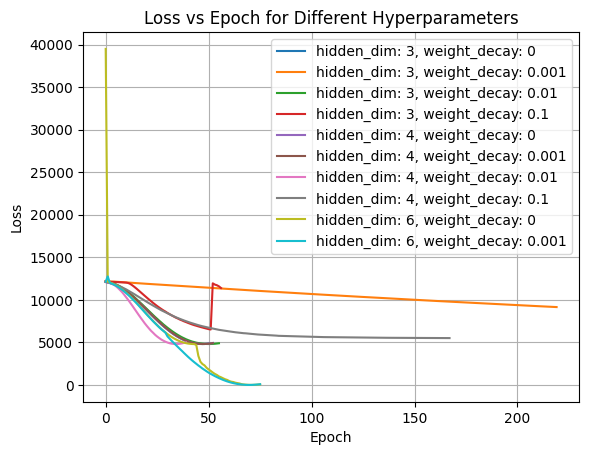

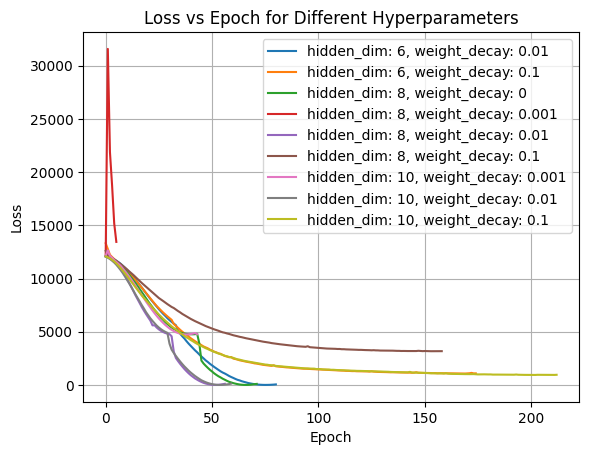

In [93]:
for param, acc in zip(params[:10], accuracies[:10]):
    accuracy = [a.detach().cpu().numpy() for a in acc]
    plt.plot(range(len(accuracy)),accuracy, label = f"hidden_dim: {param[0]}, weight_decay: {param[1]}")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch for Different Hyperparameters')
plt.legend()
plt.grid()
plt.show()


for param, acc in zip(params[10:], accuracies[10:]):
    if param[1] == 0 and param[0] == 10:
        continue
    accuracy = [a.detach().cpu().numpy() for a in acc]
    plt.plot(range(len(accuracy)),accuracy, label = f"hidden_dim: {param[0]}, weight_decay: {param[1]}")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch for Different Hyperparameters')
plt.legend()
plt.grid()
plt.show()


### train autoencoder

In [6]:
autoencoder, accuracies, ds_train, ds_test = run_train_autoencoder(test_subjects = ['1','15','3'])

Using device: cuda


/home/rand/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/rand/.local/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/rand/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/rand/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/rand/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/rand/github/XMED521/proj/sae/sae/sae_model.py:52: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel

Train Epoch: 0 [0/34 (0%)]	Loss: 319424.156250
Test Loss: 12153.0498046875
Train Epoch: 1 [0/34 (0%)]	Loss: 197794.531250


/home/rand/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rand/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Test Loss: 12114.203125
Train Epoch: 2 [0/34 (0%)]	Loss: 69715.898438
Test Loss: 12049.5546875
Train Epoch: 3 [0/34 (0%)]	Loss: 80146.453125
Test Loss: 11967.8701171875
Train Epoch: 4 [0/34 (0%)]	Loss: 378581.906250
Test Loss: 11862.046875
Train Epoch: 5 [0/34 (0%)]	Loss: 172822.546875
Test Loss: 11741.00390625
Train Epoch: 6 [0/34 (0%)]	Loss: 258251.703125
Test Loss: 11601.86328125
Train Epoch: 7 [0/34 (0%)]	Loss: 289227.000000
Test Loss: 11443.6484375
Train Epoch: 8 [0/34 (0%)]	Loss: 261654.875000
Test Loss: 11263.7724609375
Train Epoch: 9 [0/34 (0%)]	Loss: 389019.000000
Test Loss: 11076.5498046875
Train Epoch: 10 [0/34 (0%)]	Loss: 293450.500000
Test Loss: 10872.853515625
Train Epoch: 11 [0/34 (0%)]	Loss: 166127.250000
Test Loss: 10657.2412109375
Train Epoch: 12 [0/34 (0%)]	Loss: 294127.250000
Test Loss: 10423.171875
Train Epoch: 13 [0/34 (0%)]	Loss: 340010.750000
Test Loss: 10182.5947265625
Train Epoch: 14 [0/34 (0%)]	Loss: 272772.031250
Test Loss: 9939.95703125
Train Epoch: 15 [0/3

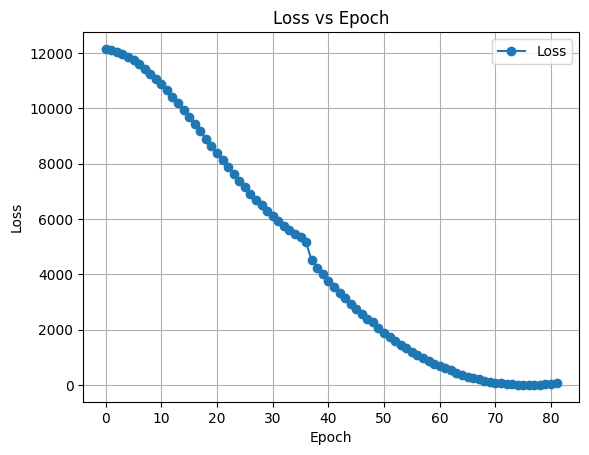

In [7]:
# COMPLETE THE PLOT FUNCTION HERE
loss = [a.detach().cpu().numpy() for a in accuracies]
plt.plot(range(len(loss)), loss, label= 'Loss',marker='o')


# Add axis labels
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Add a title (optional)
plt.title('Loss vs Epoch')

# Add a legend (optional)
plt.legend()
# Show the graph
plt.grid()
plt.show()

## Encodings Dataset

In [8]:
def generate_embeddings(embedding_model, ds):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    loader = DataLoader(ds, batch_size=1, shuffle=False, collate_fn = collate)
    embeddings = []
    labels = []
    genes = []
    subjects = []
    with torch.no_grad():
        for data, size, y, gene, subject in loader:
            data, size = data.to(device), size.to(device)
            embedding = embedding_model(data, size)
            embeddings.append(embedding)
            labels.append(y)
            genes.append(gene.cpu().item())
            subjects.append(subject.cpu().item())
    return torch.stack(embeddings, axis=0).squeeze(), torch.stack(labels,axis=0), genes, subjects


In [9]:
embeddings_train, y_train , genes_train, subjects_train = generate_embeddings(autoencoder.encoder, ds_train)
embeddings_test, y_test, genes_test, subjectes_test = generate_embeddings(autoencoder.encoder, ds_test)

In [10]:
def reshape_tensor_label(tensor, labels, gene_ids, subject_ids, num_genes, num_subjects):

    embedding_dim = tensor.shape[1]  # Get embedding dimension
    reshaped_tensor = torch.zeros((num_genes, num_subjects, embedding_dim))
    reshaped_labels = torch.zeros((num_genes, num_subjects))
    for i in range(tensor.shape[0]):
        gene_index = gene_ids[i]
        subject_index = subject_ids[i]
        reshaped_tensor[gene_index, subject_index] = tensor[i]
        reshaped_labels[gene_index, subject_index] = labels[i].item()
    return reshaped_tensor, reshaped_labels

In [11]:
reshaped_embeddings_train, reshaped_labels_train = reshape_tensor_label(embeddings_train, y_train, genes_train, subjects_train, ds_train.num_genes, ds_train.num_subjects)
reshaped_embeddings_test, reshaped_labels_test = reshape_tensor_label(embeddings_test, y_test, genes_test, subjectes_test, ds_test.num_genes, ds_test.num_subjects)

In [12]:
def transform_split(tensor, labels, split = 1):
  transformed = tensor.reshape(tensor.shape[1],tensor.shape[0]*tensor.shape[2])
  labels = labels[0,:]
  split1 = int(tensor.shape[1]*split)
  tensor1 = transformed[:split1,:]
  tensor2 = transformed[split1:,:]
  labels1 = labels[:split1]
  labels2 = labels[split1:]
  return tensor1, tensor2, labels1, labels2


In [13]:
x, _,y,_ = transform_split(reshaped_embeddings_train, reshaped_labels_train)
xval, _, yval, _ = transform_split(reshaped_embeddings_test, reshaped_labels_test)

## Prediction Models

In [68]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

class LinearLayer(nn.Module):
    def __init__(self, input_dim, output_dim):     
        super(LinearLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        scale = 1. * np.sqrt(6. / (input_dim + output_dim))
        # approximated posterior
        self.w = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-scale, scale))
        self.bias = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-scale, scale))

    def forward(self, x):     
        return torch.mm(x, self.w) + self.bias   

    
class Predictor(nn.Module):
    def __init__(self, gene_size, hidden_dim, beta):
        super(Predictor, self).__init__()
        self.input_dim = gene_size
        
        self.Layer1 = LinearLayer(self.input_dim, hidden_dim)
        self.Layer2 = LinearLayer(hidden_dim, 1)
        self.activation_fn = nn.Softplus(beta = beta)
        
    def forward(self, x):
        x1 = self.activation_fn(self.Layer1(x))
        x2 = self.Layer2(x1)
        output = torch.sigmoid(x2)
        return output, self.reg_layers()
    
    def reg_layers(self):
        reg = torch.norm(self.Layer1.w, 1) + torch.norm(self.Layer2.w, 1)
        return reg 
    

class Main_effect(nn.Module):
    def __init__(self, gene_size):
        super(Main_effect, self).__init__()
        self.input_dim = gene_size
        self.Layer1 = LinearLayer(self.input_dim, 1)

    def forward(self, x):
        x1 = self.Layer1(x)
        return torch.sigmoid(x1), self.reg_layers()

    def reg_layers(self):
        reg = torch.norm(self.Layer1.w, 1)
        return reg



## Train Gene Interaction NN and Main Effect

In [15]:
def train_predictor(model, device, train_loader, optimizer, epoch,loss_fn, reg_weight, lambda_l1):
    """Training loop."""
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output, reg = model(data)
        loss = loss_fn(output, target)+ reg_weight * reg
        #for param in model.parameters():
        #    loss += lambda_l1 * torch.sum(torch.abs(param))
        loss.backward()
        optimizer.step()


In [16]:
def test_predictor(model, device, test_loader, loss_fn):
    model.eval()
    with torch.no_grad():
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, reg = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.round()
            print(f"output: {output}, pred: {pred}, target: {target}")
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return (100.* correct / len(test_loader.dataset)), test_loss

### Train Gene Interactoin

In [82]:
def run_train_predictor(x, y, xval, yval, beta):
    learning_rate = 0.001
    epochs = 100
    reg_weight = 0.01

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    input_dim = x.shape[1]
    hidden_dim = 32

    model = Predictor(input_dim, hidden_dim, beta)  

    train_dl = DataLoader(TensorDataset(x, y.unsqueeze(1)), batch_size=1, shuffle=True)
    test_dl = DataLoader(TensorDataset(xval, yval.unsqueeze(1)), batch_size=1, shuffle=False)
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, eps=1e-8)
    model.to(device)
    accuracies = []
    losses = []
    best = 1000000
    best_state_dict = None
    patience = 8
    epoch_since_update = 0
    for epoch in range(epochs):
        train_predictor(model, device, train_dl, optimizer, epoch, loss_fn, reg_weight=reg_weight,lambda_l1 = 0.02) 
        accuracy, loss = test_predictor(model, device, test_dl, loss_fn)
        if best - loss >0:
            best = loss
            best_state_dict = model.state_dict()
            epoch_since_update = 0
        else:
            epoch_since_update +=1
            if epoch_since_update >= patience:
              model.load_state_dict(best_state_dict)
              break
        accuracies.append(accuracy)
        losses.append(loss)
        optimizer.step()
    return model, accuracies, losses



In [85]:
predictor, accuracies, losses = run_train_predictor(x,y,xval,yval,beta =5)

output: tensor([[0.]], device='cuda:0'), pred: tensor([[0.]], device='cuda:0'), target: tensor([[1.]], device='cuda:0')
output: tensor([[1.]], device='cuda:0'), pred: tensor([[1.]], device='cuda:0'), target: tensor([[1.]], device='cuda:0')
output: tensor([[1.]], device='cuda:0'), pred: tensor([[1.]], device='cuda:0'), target: tensor([[0.]], device='cuda:0')

Test set: Average loss: 66.6667, Accuracy: 1/3 (33.33%)

output: tensor([[0.]], device='cuda:0'), pred: tensor([[0.]], device='cuda:0'), target: tensor([[1.]], device='cuda:0')
output: tensor([[1.]], device='cuda:0'), pred: tensor([[1.]], device='cuda:0'), target: tensor([[1.]], device='cuda:0')
output: tensor([[1.]], device='cuda:0'), pred: tensor([[1.]], device='cuda:0'), target: tensor([[0.]], device='cuda:0')

Test set: Average loss: 66.6667, Accuracy: 1/3 (33.33%)

output: tensor([[0.]], device='cuda:0'), pred: tensor([[0.]], device='cuda:0'), target: tensor([[1.]], device='cuda:0')
output: tensor([[1.]], device='cuda:0'), pre

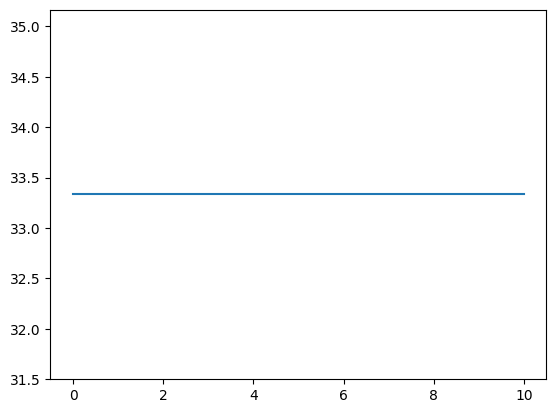

In [86]:
plt.plot(range(len(accuracies)),accuracies)

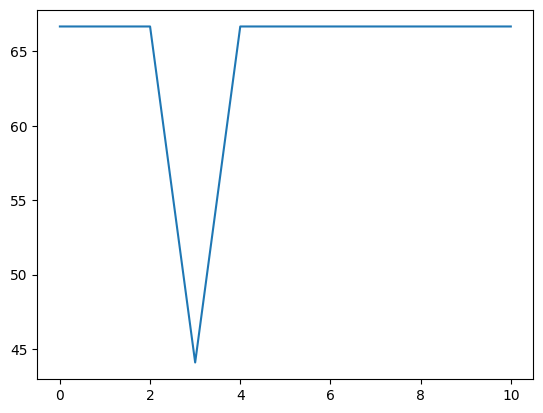

In [87]:
plt.plot(range(len(losses)),losses)

### Train Main Effect

In [64]:
def run_train_maineffect(x, y, xval, yval, beta):
    learning_rate = 0.002
    epochs = 100
    reg_weight = 0.01

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    input_dim = x.shape[1]
    hidden_dim = 32

    model = Main_effect(input_dim)  

    train_dl = DataLoader(TensorDataset(x, y.unsqueeze(1)), batch_size=1, shuffle=True)
    test_dl = DataLoader(TensorDataset(xval, yval.unsqueeze(1)), batch_size=1, shuffle=False)
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, eps=1e-8)
    model.to(device)
    accuracies = []
    losses = []
    best = 1000000
    best_state_dict = None
    patience = 8
    epoch_since_update = 0
    for epoch in range(epochs):
        train_predictor(model, device, train_dl, optimizer, epoch, loss_fn, reg_weight=reg_weight,lambda_l1 = 0.02) 
        accuracy, loss = test_predictor(model, device, test_dl, loss_fn)
        if best - loss >0:
            best = loss
            best_state_dict = model.state_dict()
            epoch_since_update = 0
        else:
            epoch_since_update +=1
            if epoch_since_update >= patience:
              model.load_state_dict(best_state_dict)
              break
        accuracies.append(accuracy)
        losses.append(loss)
        optimizer.step()
    return model, accuracies, losses

In [69]:
maineffect_model, me_accuracies, me_losses = run_train_maineffect(x,y,xval,yval,beta =5) 

output: tensor([[0.1528]], device='cuda:0'), pred: tensor([[0.]], device='cuda:0'), target: tensor([[1.]], device='cuda:0')
output: tensor([[0.]], device='cuda:0'), pred: tensor([[0.]], device='cuda:0'), target: tensor([[1.]], device='cuda:0')
output: tensor([[1.]], device='cuda:0'), pred: tensor([[1.]], device='cuda:0'), target: tensor([[0.]], device='cuda:0')

Test set: Average loss: 67.2928, Accuracy: 0/3 (0.00%)

output: tensor([[0.]], device='cuda:0'), pred: tensor([[0.]], device='cuda:0'), target: tensor([[1.]], device='cuda:0')
output: tensor([[0.]], device='cuda:0'), pred: tensor([[0.]], device='cuda:0'), target: tensor([[1.]], device='cuda:0')
output: tensor([[7.5835e-29]], device='cuda:0'), pred: tensor([[0.]], device='cuda:0'), target: tensor([[0.]], device='cuda:0')

Test set: Average loss: 66.6667, Accuracy: 1/3 (33.33%)

output: tensor([[1.7352e-16]], device='cuda:0'), pred: tensor([[0.]], device='cuda:0'), target: tensor([[1.]], device='cuda:0')
output: tensor([[0.]], de

## Shapley Taylor Interaction Index

In [90]:
import numpy as np
import torch
import torch.multiprocessing as mp

class ShapleyTaylorInteractionIndex:
    def __init__(self,
            encodings,
            predictor,
            device,
            num_permutations: int|None = None,
            ):
        """
        encodings expected dimension = (individuals,genes,gene_embedding dimension)

        """
        self.num_permutations = num_permutations
        self.encodings = encodings
        self.predictor = predictor
        self.predictor.eval()
        self.baseline = self.caluculate_baseline(self.encodings)
        self.num_individuals = self.encodings.shape[0]
        self.num_genes = self.encodings.shape[1]
        self.device = device

    def caluculate_baseline(self, encodings):
        #verify this is right
        baseline = torch.mean(encodings, dim =0)
        return baseline

    def generate_permutations(self, num_permutations, num_genes):
        permutations = [np.random.permutation(num_genes) for _ in range(num_permutations)]
        return permutations

    def generate_stratified_permutations(self, num_permutations, num_genes, encodings):
        pass

    def global_shapely_interaction_index(self, num_permutations,shapley_values = True):
        if not num_permutations:
            if not self.num_permutations:
                raise ValueError("num_permutations can not be none")
            else:
                num_permutations=self.num_permutations

        #intitialize matrix
        global_shapley_interactions = torch.zeros(size=(self.num_individuals,self.num_genes,self.num_genes))
        #make the permutation matrix
        permutations = self.generate_permutations(num_permutations,self.num_genes)
        """
        mp.set_start_method('spawn', force=True)  # Force if already set
        num_processes = mp.cpu_count()
        if num_processes > num_permutations:
          num_processes = num_permutations
        pool = mp.Pool(processes=num_processes)
        #iterate over individuals, could be parallelized
        results = pool.starmap(self.local_shapley_interaction_index, [(permutations,k, shapley_values) for k in range(self.num_individuals)])
        pool.close()
        pool.join()
        global_shapley_interactions = torch.stack(results, axis=0)
        """

        for k in range(self.num_individuals):
            global_shapley_interactions[k] = self.local_shapley_interaction_index(permutations,k, shapley_values)
            print(f"finished up to {k}")

        #check axis

        global_shapley_interactions = torch.mean(global_shapley_interactions,axis = 0)
        return global_shapley_interactions

    def local_shapley_interaction_index(self,permutations,k, shapley_values):
        local_shapley_interaction = torch.zeros(size=(len(permutations),self.num_genes,self.num_genes))
        if shapley_values:
            marginal_contribution = torch.zeros(size=(len(permutations),self.num_genes))
        for iter, pi in enumerate(permutations):
            s = []
            for i in pi:
                if i >=1: s.append(i-1)
                for j in pi[i+1:]:
                    local_shapley_interaction[iter,i,j] = self.interaction_score(s,i,j,k)
                if shapley_values:
                    marginal_contribution[iter,i] = self.marginal_contribution(s,i,k)
        local_shapley_interaction = torch.mean(local_shapley_interaction,axis=0)
        local_shapley_interaction = local_shapley_interaction + +local_shapley_interaction.T
        if shapley_values:
            local_shapley_interaction += torch.diag(torch.mean(marginal_contribution, axis =0))
        #maybe add shapley value here
        return local_shapley_interaction

    def interaction_score(self, s, i, j,k):
        s_ij = self.mask_input(s+[i,j],k).flatten().unsqueeze(0)
        s_i = self.mask_input(s+[i],k).flatten().unsqueeze(0)
        s_j = self.mask_input(s+[j],k).flatten().unsqueeze(0)
        s = self.mask_input(s,k).flatten().unsqueeze(0)
        with torch.no_grad():
            output_s_ij, _ = self.predictor(s_ij.to(self.device))
            output_s_i, _ = self.predictor(s_i.to(self.device))
            output_s_j, _ = self.predictor(s_j.to(self.device))
            output_s, _ = self.predictor(s.to(self.device))
        interaction_score = output_s_ij-output_s_i-output_s_j+output_s
        return interaction_score

    def marginal_contribution(self,s,i,k):
        s_i = self.mask_input(s+[i],k).flatten().unsqueeze(0)
        s= self.mask_input(s,k).flatten().unsqueeze(0)
        with torch.no_grad():
            output_s_i, _ = self.predictor(s_i.to(self.device))
            output_s, _ = self.predictor(s.to(self.device))
        marginal_contribution = output_s_i - output_s
        return marginal_contribution

    def mask_input(self, index_set, k):
        input = self.baseline.clone()
        input[index_set]=self.encodings[k][index_set]
        return input







### Calculate Interactions

In [53]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'



In [91]:
stii = ShapleyTaylorInteractionIndex(reshaped_embeddings_train.permute(1,0,2), predictor=predictor,device=device)

In [92]:
gene_interaction_index = stii.global_shapely_interaction_index(num_permutations=10)

finished up to 0
finished up to 1
finished up to 2
finished up to 3
finished up to 4
finished up to 5
finished up to 6
finished up to 7
finished up to 8
finished up to 9
finished up to 10
finished up to 11
finished up to 12
finished up to 13
finished up to 14
finished up to 15
finished up to 16


In [95]:
meii = ShapleyTaylorInteractionIndex(reshaped_embeddings_train.permute(1,0,2), predictor=maineffect_model,device=device)
maineffect_index = stii.global_shapely_interaction_index(num_permutations=10, shapley_values=True)

finished up to 0
finished up to 1
finished up to 2
finished up to 3
finished up to 4
finished up to 5
finished up to 6
finished up to 7
finished up to 8
finished up to 9
finished up to 10
finished up to 11
finished up to 12
finished up to 13
finished up to 14
finished up to 15
finished up to 16


### Interaction Heatmaps

In [93]:
import seaborn as sns

<Axes: >

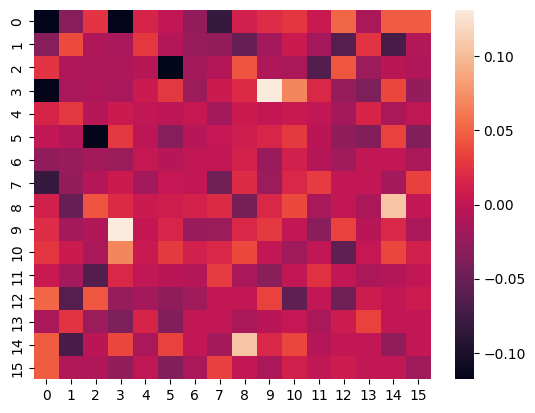

In [94]:
sns.heatmap(gene_interaction_index)

<Axes: >

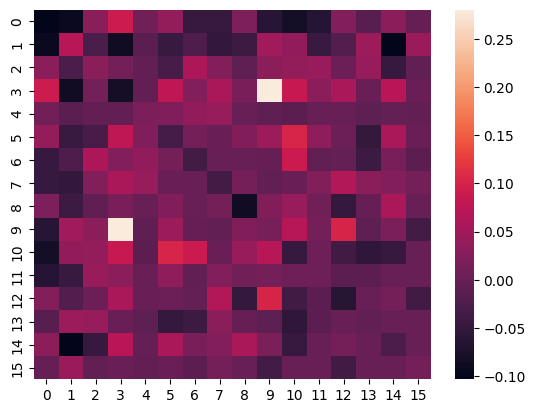

In [96]:
sns.heatmap(maineffect_index)

In [57]:
# Create a mask with zeros in the lower triangle and ones in the upper triangle
mask = torch.triu(torch.ones_like(gene_interaction_index), diagonal=1)

# Multiply the interaction_index by the mask
upper_interaction_index = gene_interaction_index * mask

## Residual Permutation Dataset

Should I permute just over test set and train set seperatley or together.

In [146]:
def compute_residual_labels(main_effect, x, y, device):
    main_effect.to(device)
    x = x.to(device)
    y = y.to(device)
    main_effect.eval()
    with torch.no_grad():
        # can add this in if we need to use a dataloader for bigger datasets
       # dl = DataLoader(TensorDataset(x, y.unsqueeze(1)), batch_size=16, shuffle=True)
        outputs, _ = main_effect(x)
        print(outputs)
    residuals = y- outputs.squeeze()
    print(residuals)
    return residuals, outputs.squeeze()

In [147]:
def generate_permutated_dataset(main_effect, x,y, device):
    residuals, outputs = compute_residual_labels(main_effect, x, y, device)
    permutation = torch.randperm(residuals.shape[0])
    permuted_residuals = residuals[permutation]
    
    permuted_y = permuted_residuals + outputs
    return permuted_y

In [110]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [148]:
permuted_y = generate_permutated_dataset(maineffect_model, x, y, device)

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
tensor([ 0.,  0.,  0.,  0.,  0.,  0., -1., -1., -1.,  0., -1.,  1.,  1., -1.,
        -1., -1., -1.], device='cuda:0')


In [141]:
y.shape

torch.Size([17])

In [142]:
permuted_y.shape

torch.Size([17])

In [143]:
permuted_y

tensor([ 0., -1., -1., -1., -1.,  1.,  1.,  2.,  1.,  0.,  1.,  0., -1.,  0.,
         0.,  0.,  2.], device='cuda:0')